In [ ]:
import pandas as pd

In [ ]:
!pip install transformers


In [ ]:
import pandas as pd
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import tensorflow_hub as hub
from tqdm import tqdm
from tqdm import tqdm_notebook
from sklearn.metrics import auc
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import AutoTokenizer,BertTokenizer,TFBertModel,TFOpenAIGPTModel,OpenAIGPTTokenizer,DistilBertTokenizer, TFDistilBertModel,XLMTokenizer, TFXLMModel
from transformers import TFAutoModel, AutoTokenizer
from sklearn.metrics import roc_curve,confusion_matrix,auc
from tokenizers import Tokenizer, models, pre_tokenizers, decoders, processors
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import matplotlib as mpl


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.initializers import Constant

In [ ]:
from google.colab import files

uploaded = files.upload()

In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 452 kB 35.1 MB/s 
     |████████████████████████████████| 132 kB 77.3 MB/s 
     |████████████████████████████████| 213 kB 81.9 MB/s 
     |████████████████████████████████| 127 kB 71.3 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
df = pd.read_csv('overruling.csv')

In [ ]:
df

,label,text
0,0,876 f.3d at 1306.
1,0,the analysis below is included to satisfy our ...
2,0,my colleagues argue that their imposition of s...
3,0,"further, the easement is silent with regard to..."
4,1,"for the reasons that follow, we approve the fi..."
...,...,...
2395,1,"in the event the trial court cannot, for reaso..."
2396,1,to the extent that our holdings in patman v. s...
2397,1,we disapprove orange county v. sealy to the ex...
2398,1,to the extent that our previous opinion in sta...


In [ ]:
df = df.dropna()

In [ ]:
df = df.sample(frac=1)

In [ ]:
df

,label,text
1196,0,"even if his earlier filings had passed muster,..."
1323,0,according to deposition testimony from a staff...
38,0,see a.r.s. 13-105(9).
1678,1,"accordingly, from this time forward, the holdi..."
40,1,"to the extent that langley, supra, supports th..."
...,...,...
940,0,"id. (quoting riyaz a. kanji, the proper scope ..."
1238,0,appellant francisco salazar appeals his convic...
650,0,"when asked what happened and who stabbed him, ..."
1690,0,"those narrow circumstances, however, only incl..."


In [ ]:
df_train = df[:1920]

In [ ]:
df_test = df[1920:]

In [ ]:
len(df_train)

1920

In [ ]:
len(df_test)

480

In [ ]:
df_train.to_csv('train_transformers.csv')
df_test.to_csv('test_transformers.csv')

In [ ]:
df_test = pd.read_csv('test_transformers.csv')
df_train = pd.read_csv('train_transformers.csv')

In [ ]:
from datasets import load_dataset
dataset = load_dataset('csv', data_files={'train': ['train_transformers.csv'],
                                              'test': 'test_transformers.csv'})

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-661d673038dc2bd4/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 1920
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 480
    })
})

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("roberta-base")


def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)


tokenized_datasets = dataset.map(tokenize_function, batched=True)

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42)
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42)

In [ ]:
small_train_dataset

Dataset({
    features: ['label', 'text', 'input_ids', 'attention_mask'],
    num_rows: 1920
})

In [ ]:

small_eval_dataset

Dataset({
    features: ['label', 'text', 'input_ids', 'attention_mask'],
    num_rows: 480
})

In [ ]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator(return_tensors="tf")

In [ ]:
tf_train_dataset = small_train_dataset.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["labels"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8,
)

tf_validation_dataset = small_eval_dataset.to_tf_dataset(
    columns=["attention_mask", "input_ids"],
    label_cols=["labels"],
    shuffle=False,
    collate_fn=data_collator,
    batch_size=8,
)

In [ ]:
import tensorflow as tf
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy(),
)

model.fit(tf_train_dataset, validation_data=tf_validation_dataset, epochs=3)

Epoch 1/3
240/240 [==============================] - 279s 1s/step - loss: 0.3222 - sparse_categorical_accuracy: 0.8313 - val_loss: 0.1454 - val_sparse_categorical_accuracy: 0.9458
Epoch 2/3
240/240 [==============================] - 259s 1s/step - loss: 0.0771 - sparse_categorical_accuracy: 0.9766 - val_loss: 0.1592 - val_sparse_categorical_accuracy: 0.9500
Epoch 3/3
240/240 [==============================] - 259s 1s/step - loss: 0.0398 - sparse_categorical_accuracy: 0.9870 - val_loss: 0.1673 - val_sparse_categorical_accuracy: 0.9542


In [ ]:
model.summary()

Model: "tf_roberta_for_sequence_classification_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 roberta (TFRobertaMainLayer  multiple                 124055040 
 )                                                               
                                                                 
 classifier (TFRobertaClassi  multiple                 592130    
 ficationHead)                                                   
                                                                 
Total params: 124,647,170
Trainable params: 124,647,170
Non-trainable params: 0
_________________________________________________________________


In [ ]:
y_test=np.array(df_test['label'])

In [ ]:
y_predict=model.predict(tf_validation_dataset, verbose=1)
# y_predict[ y_predict> 0.5] = 1
# y_predict[y_predict <= 0.5] = 0
# plot_cm(y_valid, y_predict, 'Distil BERT Performance-Confusion Matrix')

60/60 [==============================] - 20s 332ms/step


In [ ]:
fpr_a, tpr_a, _ = roc_curve(y_test, y_pred_a)
roc_auc_a = auc(fpr_a, tpr_a)
# roc_curve_plot(fpr,tpr,roc_auc)

NameError: ignored

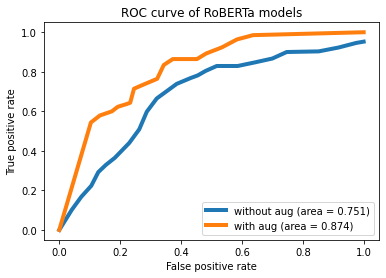

In [ ]:
plt.plot(fpr, tpr,linewidth=4, label='without aug (area = {:.3f})'.format(roc_auc))
plt.plot(fpr_a, tpr_a, linewidth=4, label='with aug (area = {:.3f})'.format(roc_auc_a))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve of RoBERTa models')
plt.legend(loc='best')
plt.savefig("ROC_ROBERTA.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt

In [ ]:
precision_score(y_test, y_pred)

0.88029843


In [ ]:
recall_score(y_test, y_pred)

0.86269351


In [ ]:
f1_score(y_test, y_pred)

0.87140706


In [ ]:
from sklearn.metrics import roc_curve,confusion_matrix,auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr) #curve for model without aug

fpr_a, tpr_a, _ = roc_curve(y_test, y_pred_a)
roc_auc_a = auc(fpr_a, tpr_a) #curve for model with aug

plt.plot(fpr, tpr,linewidth=4, label='without aug (area = {:.3f})'.format(roc_auc))
plt.plot(fpr_a, tpr_a, linewidth=4, label='with aug (area = {:.3f})'.format(roc_auc_a))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve of RoBERTa models')
plt.legend(loc='best')
plt.savefig("ROC_ROBERTA.pdf", format="pdf", bbox_inches="tight")
plt.show()